# Exercise 8: Semantic Segmentation with Deep Learning

In the previous exercise, we implemented a full routine for training and validating DL models for image classification.
Now, we shall take it to the next level and perform pixel-wise classification, also known as semantic segmentation.
This is of particular interest to remote sensing, as it allows us to e.g. obtain spatially well-resolved land cover maps, among other products.

The basic ingredients are exactly the same as for image classification (optimiser, loss function, training loop, etc.). We do have some changes to make, though:
* Dataset: this time, we don't just want a single output number (class), but one value per spatial location. Essentially, our dataset should also provide a second image where each pixel has the class index as its value.
* Model: likewise, we need a suitable model that provides spatial outputs rather than a single class vector. You have seen some examples in the lecture. In this exercise we shall use a flavour of the [Hypercolumn](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Hariharan_Hypercolumns_for_Object_2015_CVPR_paper.pdf) to do this job.

## 1. Setup

### 1.1 Install dependencies

Please re-run this as we now need another package (for downloading the data).

In [3]:
import sys
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm                      # this gives us a pretty progress bar

# for downloading files from Google drive
!{sys.executable} -m pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
     |████████████████████████████████| 138 kB 7.0 MB/s 
     |████████████████████████████████| 61 kB 24.5 MB/s 
  Created wheel for gdown: filename=gdown-4.0.2-py3-none-any.whl size=10598 sha256=741f3280fc27797c8dc058eec00516a0173beb39932dfcd2559d1a53ac02f348
  Stored in directory: /home/bkellenb/.cache/pip/wheels/75/20/08/4d138cf98df8fe9e14e369c7de79e01c5cabca55b0f58cef3a
Successfully built gdown


### 1.2 Check if GPU available

This is even more important for semantic segmentation, as our models and data tensors are going to be significantly larger.

Run the following code block and proceed if the response is `True`. Else see an instructor.

In [4]:
import torch

print(torch.cuda.is_available())

True


### 1.3 Random seed

In [2]:
seed = 323444           # the seed value used to initialise the random number generator of PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## 2. Dataset

For this exercise we shall be using the [ISPRS Vaihingen](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-vaihingen/) semantic segmentation dataset.
This is a set of fully-labelled satellite image-segmentation mask pairs, with 9cm resolution and six land cover classes: Impervious, Buildings, Low Vegetation, Tree, Car, Clutter. The images come from a large satellite scene over the town Vaihingen in Germany and were divided into 33 patches, some of which are available with ground truth. These patches are still too large for our model – we would quickly run out of GPU memory if we tried to process an image of e.g. 4000x3000 pixels. Hence, they need to be further divided into even smaller patches. This has already been done for you – all you need to do is to download the image-label pair patches (sized 512x512 pixels) by running the code cell below.

In [6]:
!gdown --id 1S8oCD1fK4_l2L6lYwuHOHcNtKhRYg19b

!tar -xf vaihingen_512x512_full.tar.gz
data_root = 'dataset_512x512_full'

Like before, we need to wrap these images in a Dataset class.
It's quite involved this time, however, since we don't just have simple RGB images, but need to collect multiple satellite products. The code below does all of this for you.

In [32]:
import os
import torch
from torch.utils.data import dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T      # transformations that can be used e.g. for data conversion or augmentation
import numpy as np
from PIL import Image


class VaihingenDataset(dataset.Dataset):
    '''
        Custom Dataset class that loads images and ground truth segmentation
        masks from a directory.
    '''

    # image statistics, calculated in advance as averages across the full
    # training data set
    IMAGE_MEANS = (
        (121.03431026287558, 82.52572736507886, 81.92368178210943),     # IR-R-G tiles
        (285.34753853934154),                                           # DSM
        (31.005143030549313)                                            # nDSM
    )
    IMAGE_STDS = (
        (54.21029197978022, 38.434924159900554, 37.040640374137475),    # IR-R-G tiles
        (6.485453035150256),                                            # DSM
        (36.040236155124326)                                            # nDSM
    )


    # label class names
    LABEL_CLASSES = (
        'Impervious', 'Buildings', 'Low Vegetation', 'Tree', 'Car', 'Clutter'
    )


    def __init__(self, data_root):
        '''
            Dataset class constructor. Here we initialize the dataset instance
            and retrieve file names (and other metadata, if present) for all the
            images and labels (ground truth semantic segmentation maps).
        '''
        super().__init__()

        self.data_root = data_root

        # find all images. In our case they are listed in a CSV file called
        # "fileList.csv" under the "data_root"
        with open(os.path.join(self.data_root, 'fileList.csv'), 'r') as f:
            lines = f.readlines()
        
        # parse CSV lines into data tokens: first column is the label file, the
        # remaining ones are the image files
        self.data = []
        for line in lines[1:]:      # skip header
            self.data.append(line.strip().split(','))


    def __len__(self):
        '''
            This function tells the Data Loader how many images there are in
            this dataset.
        '''
        return len(self.data)

    
    def __getitem__(self, idx):
        '''
            Here's where we load, prepare, and convert the images and
            segmentation mask for the data element at the given "idx".
        '''
        item = self.data[idx]

        # load segmentation mask (first column of CSV file)
        labels = Image.open(os.path.join(self.data_root, 'labels', item[0]))
        labels = np.array(labels, dtype=np.int64)   # convert to NumPy array temporarily

        # load all images (remaining columns of CSV file)
        images = [Image.open(os.path.join(self.data_root, 'images', i)) for i in item[1:]]

        # NOTE: at this point it would make sense to perform data augmentation.
        # However, the default augmentations built-in to PyTorch (resp.
        # Torchvision) (i.) only support RGB images; (ii.) only work on the
        # images themselves. In our case, however, we have multispectral data
        # and need to also transform the segmentation mask.
        # This is not difficult to do, but goes beyond the scope of this exercise.
        # For the sake of brevity, we'll leave it out accordingly.
        # What we will have to do, however, is to normalize the image data.
        for i in range(len(images)):
            img = np.array(images[i], dtype=np.float32)                 # convert to NumPy array (very similar to torch.Tensor below)
            img = (img - self.IMAGE_MEANS[i]) / self.IMAGE_STDS[i]      # normalize
            images[i] = img

        # finally, we need to convert our data into the torch.Tensor format. For
        # the images, we already have a "ToTensor" transform available, but we
        # need to concatenate the images together.
        tensors = [T.ToTensor()(i) for i in images]
        tensors = torch.cat(tensors, dim=0).float()         # concatenate along spectral dimension and make sure it's in 32-bit floating point

        # For the labels, we need to convert the PIL image to a torch.Tensor.
        labels = torch.from_numpy(labels).long()            # labels need to be in 64-bit integer format

        return tensors, labels





# we also create a function for the data loader here (see Section 2.6 in Exercise 6)
def load_dataloader(batch_size, split='train'):
  return DataLoader(
      VaihingenDataset(os.path.join(data_root, split)),
      batch_size=batch_size,
      shuffle=(split=='train'),       # we shuffle the image order for the training dataset
      num_workers=2                   # perform data loading with two CPU threads
  )

Let's visualise some images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image tensor size: torch.Size([5, 512, 512])
Label tensor size: torch.Size([512, 512])


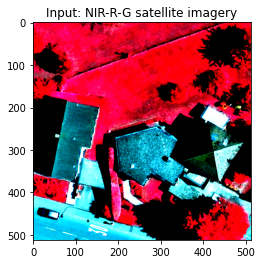

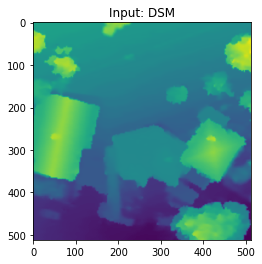

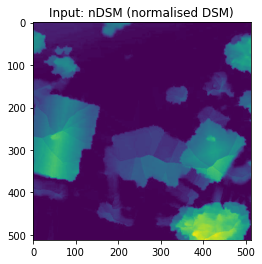

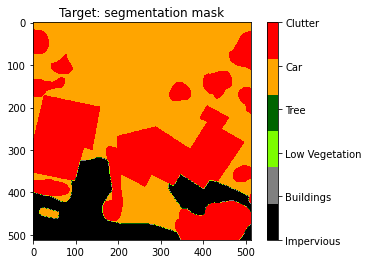

In [45]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#discrete color scheme
cMap = ListedColormap(['black', 'grey', 'lawngreen', 'darkgreen', 'orange', 'red'])     #  'Impervious', 'Buildings', 'Low Vegetation', 'Tree', 'Car', 'Clutter'

dataset_train = VaihingenDataset(os.path.join(data_root, 'train'))

# draw a random sample
idx = torch.randint(0, len(dataset_train), (1,))
data, target = dataset_train.__getitem__(idx)
print(f'Image tensor size: {data.size()}')
print(f'Label tensor size: {target.size()}')

# visualise
plt.figure()
plt.imshow(data[:3,...].permute(1,2,0).numpy())     # first three bands: NIR-R-G
plt.title('Input: NIR-R-G satellite imagery')
plt.show()
plt.figure()
plt.imshow(data[3,...].squeeze().numpy())           # band 4: DSM
plt.title('Input: DSM')
plt.show()
plt.imshow(data[4,...].squeeze().numpy())           # band 5: nDSM
plt.title('Input: nDSM (normalised DSM)')
plt.show()
fig = plt.figure()
cax = plt.imshow(target.squeeze().numpy(), cmap=cMap)                # target: segmentation mask
cbar = fig.colorbar(cax, ticks=list(range(len(dataset_train.LABEL_CLASSES))))
cbar.ax.set_yticklabels(list(dataset_train.LABEL_CLASSES))
plt.title('Target: segmentation mask')
plt.show()


## 3. Model

Now let's define our semantic segmentation model! Technically, the model must produce an output that is exactly the same size as its input in space. As stated above we shall use a [Hypercolumn](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Hariharan_Hypercolumns_for_Object_2015_CVPR_paper.pdf) for this task. This is a _Fully Convolutional Network_ (FCN), which means that it does not use a single fully-connected layer, but always preserves some notion of space (so it can use convolutions, pooling, ReLU, etc.). The nice property of FCNs is that they can accept any spatial input of sufficient size and can scale up to the limits of the GPU memory.

A Hypercolumn basically performs downsampling via convolutions, poolings, etc., like you have been doing in Exercise 6 for image classification. However, unlike a classifier, it keeps every intermediate output, upsamples (interpolates) them to the original image's size, stacks them together to a large tensor (a hypercolumn) and uses this to perform pixel-wise classification:

![Hypercolumn](https://www.researchgate.net/profile/Devis-Tuia/publication/323273293/figure/fig3/AS:614258178027521@1523461970498/Hypercolumn-based-architecture-used-in-all-our-experiments-Note-that-all-the-layers-are.png)
Image source: Marcos, D., Volpi, M., Kellenberger, B. and Tuia, D., 2018. Land cover mapping at very high resolution with rotation equivariant CNNs: Towards small yet accurate models. ISPRS journal of photogrammetry and remote sensing, 145, pp.96-107.


Let's implement a Hypercolumn with the following architecture:
1. BLOCK 1:
    1. 2D convolution, 32 kernels of size 5x5, stride 4, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
2. BLOCK 2:
    1. 2D convolution, 64 kernels of size 5x5, stride 4, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
3. BLOCK 3:
    1. 2D convolution, 128 kernels of size 5x5, stride 2, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
4. BLOCK 4:
    1. 2D convolution, 256 kernels of size 3x3, stride 1, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
5. HYPERCOLUMN: here you do the following:
    1. Take all outputs of the input and BLOCKs 1, 2, 3 and 4 (after the ReLU)
    2. Interpolate them to the original input's spatial size (tip: use an instance of [torch.nn.Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html))
    3. Concatenate them together (tip: `torch.cat((tensor1, tensor2, ...), dim=1))
6. FINAL BLOCK: this works on the output of 5. HYPERCOLUMN:
    1. 2D convolution, 256 kernels of size 1x1, stride 1, zero-padding 0
    2. Batch Normalisation
    3. ReLU
    4. 2D convolution, 6 kernels of size 1x1, stride 1, zero-padding 0 (output of model)

In [34]:
import torch.nn as nn


class Hypercolumn(nn.Module):

    def __init__(self):
        super(Hypercolumn, self).__init__()

        #TODO: define your architecture and forward pass here
        self.block1 = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=5, stride=4),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=4),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.Conv2d(485, 256, kernel_size=1, stride=1),           # 485 = 256 + 128 + 64 + 32 + 5 (input bands)
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 6, kernel_size=1, stride=1)
        )
    

    def forward(self, x):
        #TODO
        upsample = nn.Upsample(size=(x.size(2), x.size(3)))
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)

        hypercol = torch.cat(
            (x, upsample(x1), upsample(x2), upsample(x3), upsample(x4)),
            dim=1
        )
        return self.final(hypercol)

Let's test it!

In [35]:
dataloader_train = load_dataloader(batch_size=2, split='train')
model = Hypercolumn()

data, _ = iter(dataloader_train).__next__()
pred = model(data)

assert pred.size(1) == len(dataset_train.LABEL_CLASSES), f'ERROR: invalid number of model output channels (should be # classes {len(dataset_train.LABEL_CLASSES)}, got {pred.size(1)})'
assert pred.size(2) == data.size(2), f'ERROR: invalid spatial height of model output (should be {data.size(2)}, got {pred.size(2)})'
assert pred.size(3) == data.size(3), f'ERROR: invalid spatial width of model output (should be {data.size(3)}, got {pred.size(3)})'

## 4. Model training

All the rest is exactly the same principle as for the image classification part!
This means that you can mostly re-use the code cells from Section 4 ("Implement training routine") of the previous exercise.

In [36]:
#TODO: complete criterion block here
criterion = nn.CrossEntropyLoss()

In [37]:
#TODO: complete optimiser block here
from torch.optim import SGD

def setup_optimiser(model, learning_rate, weight_decay):
  return SGD(
    model.parameters(),
    learning_rate,
    weight_decay
  )

In [38]:
#TODO: complete training block here
from tqdm.notebook import trange      # pretty progress bar


def train_epoch(data_loader, model, optimiser, device):

  # set model to training mode. This is important because some layers behave differently during training and testing
  model.train(True)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):

    #TODO: implement the training step here. Check the introductory slides if you need help.

    # put data and target onto correct device
    data, target = data.to(device), target.to(device)

    # reset gradients
    optimiser.zero_grad()

    # forward pass
    pred = model(data)

    # loss
    loss = criterion(pred, target)

    # backward pass
    loss.backward()

    # parameter update
    optimiser.step()

    # stats update
    loss_total += loss.item()
    oa_total += torch.mean((pred.argmax(1) == target).float()).item()

    # format progress bar
    pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * oa_total/(idx+1)
    ))
    pBar.update(1)
  
  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return model, loss_total, oa_total

In [39]:
#TODO: complete validation block here
def validate_epoch(data_loader, model, device):       # note: no optimiser needed

  # set model to evaluation mode
  model.train(False)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):
    with torch.no_grad():

      #TODO: likewise, implement the validation routine. This is very similar, but not identical, to the training steps.

      # put data and target onto correct device
      data, target = data.to(device), target.to(device)

      # forward pass
      pred = model(data)

      # loss
      loss = criterion(pred, target)

      # stats update
      loss_total += loss.item()
      oa_total += torch.mean((pred.argmax(1) == target).float()).item()

      # format progress bar
      pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
        loss_total/(idx+1),
        100 * oa_total/(idx+1)
      ))
      pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return loss_total, oa_total

The rest (Section 5 and later from Exercise 7) is also the same, but we change the model name and parameters a bit here, which is why these code blocks are given to you below.

In [41]:
import glob

os.makedirs('cnn_states/Hypercolumn', exist_ok=True)

def load_model(epoch='latest'):
  model = Hypercolumn()
  modelStates = glob.glob('cnn_states/Hypercolumn/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m.replace('cnn_states/Hypercolumn/','').replace('.pth', '')) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'cnn_states/Hypercolumn/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch):
  torch.save(model.state_dict(), open(f'cnn_states/Hypercolumn/{epoch}.pth', 'wb'))

In [43]:
# define hyperparameters
device = 'cuda'
start_epoch = 0        # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
batch_size = 2
learning_rate = 0.1
weight_decay = 0.001
num_epochs = 10



# initialise data loaders
dl_train = load_dataloader(batch_size, 'train')
dl_val = load_dataloader(batch_size, 'val')

# load model
model, epoch = load_model(epoch=start_epoch)
optim = setup_optimiser(model, learning_rate, weight_decay)

# do epochs
while epoch < num_epochs:

  # training
  model, loss_train, oa_train = train_epoch(dl_train, model, optim, device)

  # validation
  loss_val, oa_val = validate_epoch(dl_val, model, device)

  # print stats
  print('[Ep. {}/{}] Loss train: {:.2f}, val: {:.2f}; OA train: {:.2f}, val: {:.2f}'.format(
      epoch+1, num_epochs,
      loss_train, loss_val,
      100*oa_train, 100*oa_val
  ))

  # save model
  epoch += 1
  save_model(model, epoch)

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 1/10] Loss train: 0.81, val: 0.54; OA train: 66.81, val: 78.12


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 2/10] Loss train: 0.65, val: 0.61; OA train: 73.08, val: 72.70


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 3/10] Loss train: 0.59, val: 1.24; OA train: 76.50, val: 64.29


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 4/10] Loss train: 0.58, val: 1.84; OA train: 76.60, val: 61.00


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 5/10] Loss train: 0.54, val: 0.44; OA train: 78.45, val: 83.71


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 6/10] Loss train: 0.52, val: 0.53; OA train: 79.14, val: 81.35


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 7/10] Loss train: 0.53, val: 0.49; OA train: 78.85, val: 79.44


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 8/10] Loss train: 0.51, val: 0.44; OA train: 79.76, val: 81.88


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 9/10] Loss train: 0.48, val: 0.56; OA train: 81.06, val: 76.83


  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

[Ep. 10/10] Loss train: 0.48, val: 0.45; OA train: 81.16, val: 81.93


## 5. Model validation

Like in Exercise 7 we could do a final accuracy evaluation now. We don't have access to the Vaihingen dataset's test image labels, since these are hidden on an official Web evaluation server (the Vaihingen dataset was at some point a contest where people could submit their scores and compete against each other!).

But, we can do something else that we could not do in Exercise 7: visualise our results! Our model provides segmentation masks after all… So let's do this!

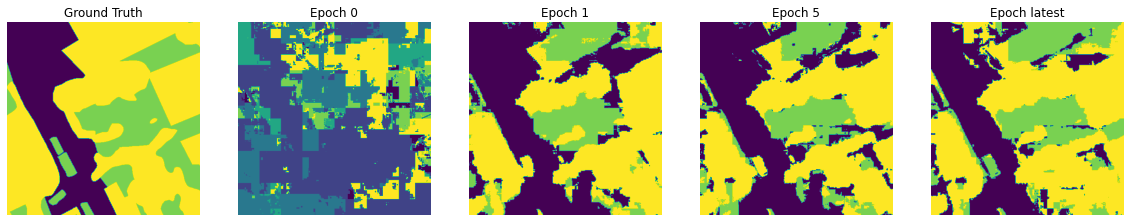

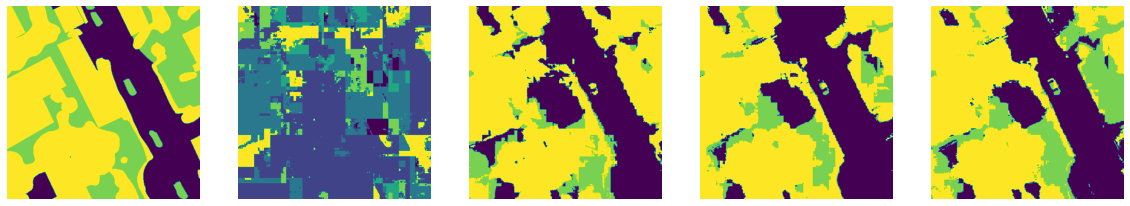

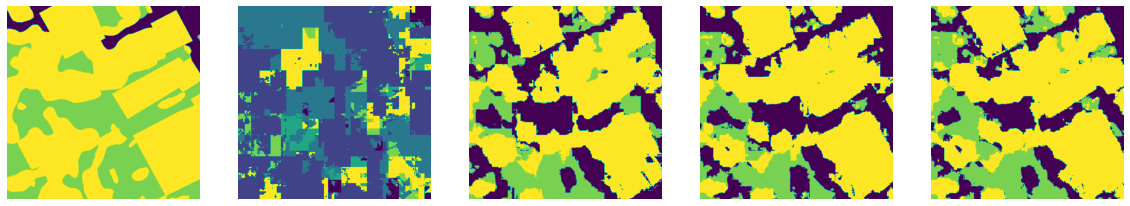

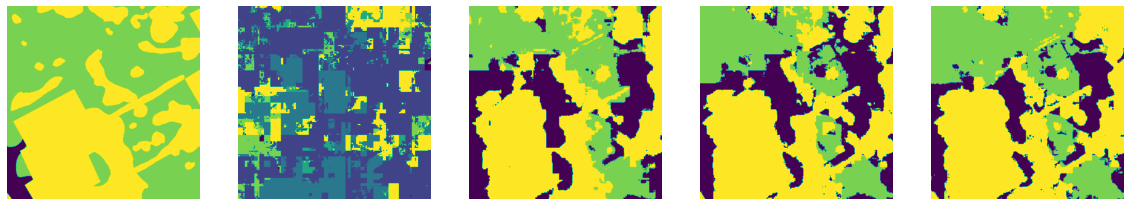

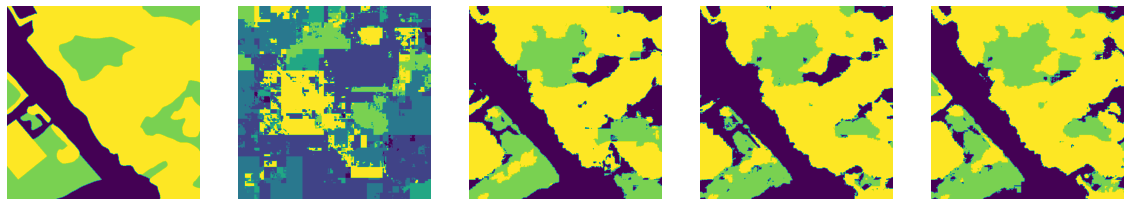

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize(dataLoader, epochs, numImages=5):
  models = [load_model(e)[0] for e in epochs]
  numModels = len(models)
  for idx, (data, labels) in enumerate(dataLoader):
    if idx == numImages:
      break

    _, ax = plt.subplots(nrows=1, ncols=numModels+1, figsize = (20, 15))

    # plot ground truth
    ax[0].imshow(labels[0,...].cpu().numpy())
    ax[0].axis('off')
    if idx == 0:
      ax[0].set_title('Ground Truth')

    for mIdx, model in enumerate(models):
      model = model.to(device)
      with torch.no_grad():
        pred = model(data.to(device))

        # get the label (i.e., the maximum position for each pixel along the class dimension)
        yhat = torch.argmax(pred, dim=1)

        # plot model predictions
        ax[mIdx+1].imshow(yhat[0,...].cpu().numpy())
        ax[mIdx+1].axis('off')
        if idx == 0:
          ax[mIdx+1].set_title(f'Epoch {epochs[mIdx]}')


# visualize predictions for a number of epochs
dl_val_single = load_dataloader(1, 'val')

# load model states at different epochs
epochs = [0, 1, 5, 'latest']                                          #TODO: modify this vector according to your wishes, resp. for how many model states you have trained

visualize(dl_val_single, epochs, numImages=5)